In [111]:
import pandas as pd
import numpy as np
import seaborn as sns
import time

import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
from scipy.stats import norm, skew

from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor

In [62]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [63]:
import os
os.chdir('/content/gdrive/My Drive/My_Colab_Works')

In [64]:
train_data = pd.read_csv('/content/gdrive/My Drive/My_Colab_Works/Kaggle_House_Price/data/train.csv')
test_data = pd.read_csv('/content/gdrive/My Drive/My_Colab_Works/Kaggle_House_Price/data/test.csv')

In [65]:
train_y = train_data.pop('SalePrice')

In [66]:
dataset_df = pd.concat([train_data, test_data])

In [67]:
dataset_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [68]:
dataset_df.shape

(2919, 80)

In [69]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

In [70]:
categorical_cols = []
numerical_cols = []
for col in dataset_df:
    if dataset_df[col].dtype != object:
      numerical_cols.append(col)
    else:
      categorical_cols.append(col)

In [71]:
for col in categorical_cols:
  print(str(col) + str(dataset_df[col].unique()))

MSZoning['RL' 'RM' 'C (all)' 'FV' 'RH' nan]
Street['Pave' 'Grvl']
Alley[nan 'Grvl' 'Pave']
LotShape['Reg' 'IR1' 'IR2' 'IR3']
LandContour['Lvl' 'Bnk' 'Low' 'HLS']
Utilities['AllPub' 'NoSeWa' nan]
LotConfig['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
LandSlope['Gtl' 'Mod' 'Sev']
Neighborhood['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']
Condition1['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']
Condition2['Norm' 'Artery' 'RRNn' 'Feedr' 'PosN' 'PosA' 'RRAn' 'RRAe']
BldgType['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']
HouseStyle['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']
RoofStyle['Gable' 'Hip' 'Gambrel' 'Mansard' 'Flat' 'Shed']
RoofMatl['CompShg' 'WdShngl' 'Metal' 'WdShake' 'Membran' 'Tar&Grv' 'Roll'
 'ClyTile']
Exterior1st['VinylSd' 'MetalSd' 'Wd Sdn

In [72]:
dataset_df[numerical_cols].describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,2919.000000,2919.000000,2433.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2896.000000,2918.000000,2918.000000,2918.000000,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000,2917.000000,2917.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2760.000000,2918.000000,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,1460.000000,57.137718,69.305795,10168.114080,6.089072,5.564577,1971.312778,1984.264474,102.201312,441.423235,49.582248,560.772104,1051.777587,1159.581706,336.483727,4.694416,1500.759849,0.429894,0.061364,1.568003,0.380267,2.860226,1.044536,6.451524,0.597122,1978.113406,1.766621,472.874572,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,6.213087,2007.792737
std,842.787043,42.517628,23.344905,7886.996359,1.409947,1.113131,30.291442,20.894344,179.334253,455.610826,169.205611,439.543659,440.766258,392.362079,428.701456,46.396825,506.051045,0.524736,0.245687,0.552969,0.502872,0.822693,0.214462,1.569379,0.646129,25.574285,0.761624,215.394815,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,2.714762,1.314964
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,730.500000,20.000000,59.000000,7478.000000,5.000000,5.000000,1953.500000,1965.000000,0.000000,0.000000,0.000000,220.000000,793.000000,876.000000,0.000000,0.000000,1126.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1960.000000,1.000000,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,1460.000000,50.000000,68.000000,9453.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.500000,0.000000,467.000000,989.500000,1082.000000,0.000000,0.000000,1444.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1979.000000,2.000000,480.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,2189.500000,70.000000,80.000000,11570.000000,7.000000,6.000000,2001.000000,2004.000000,164.000000,733.000000,0.000000,805.500000,1302.000000,1387.500000,704.000000,0.000000,1743.500000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,2919.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,2336.000000,6110.000000,5095.000000,2065.000000,1064.000000,5642.000000,3.000000,2.000000,4.000000,2.000000,8.000000,3.000000,15.000000,4.000000,2207.000000,5.000000,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


In [73]:
def missing_vals_overview(df):

  total_count = df.count()
  n_miss = df.isnull().sum()
  perc_miss = df.isnull().sum()/df.isnull().count() * 100

  cols = ['total', 'n_miss', '%_miss']
  descr_df = pd.concat([total_count, n_miss, perc_miss], axis=1)
  descr_df.columns = cols
  return descr_df

In [74]:
descr_df = missing_vals_overview(dataset_df)
descr_df.loc[descr_df['n_miss'] > 0]

,total,n_miss,%_miss
MSZoning,2915,4,0.137033
LotFrontage,2433,486,16.649538
Alley,198,2721,93.216855
Utilities,2917,2,0.068517
Exterior1st,2918,1,0.034258
Exterior2nd,2918,1,0.034258
MasVnrType,2895,24,0.822199
MasVnrArea,2896,23,0.787941
BsmtQual,2838,81,2.774923
BsmtCond,2837,82,2.809181


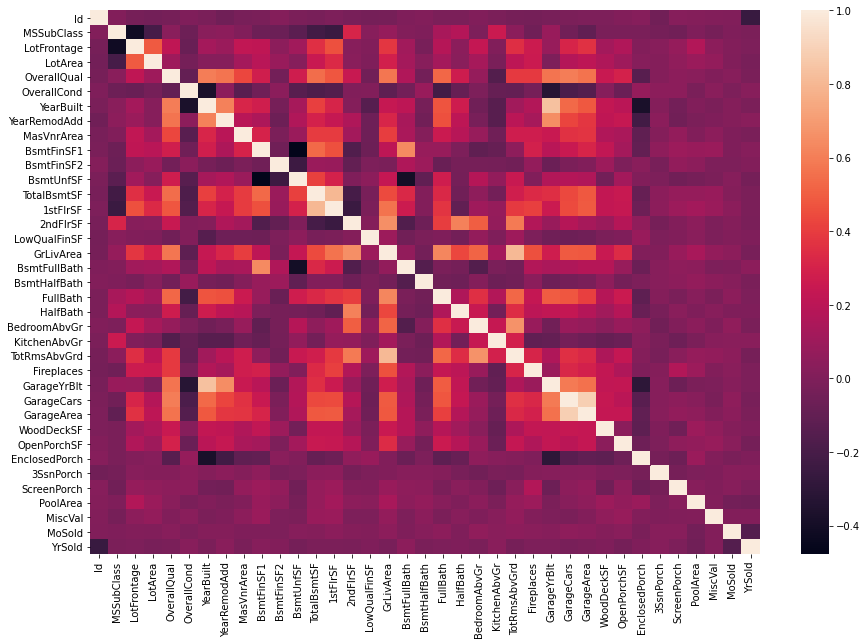

In [75]:
plt.figure(figsize=(15, 10))
sns.heatmap(dataset_df.corr())

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


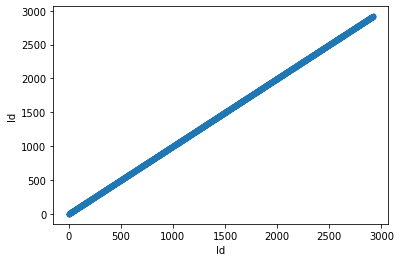

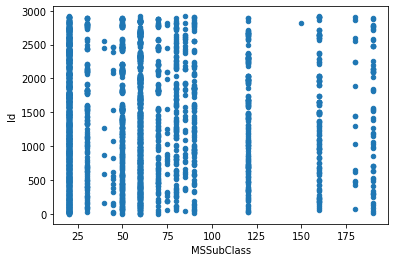

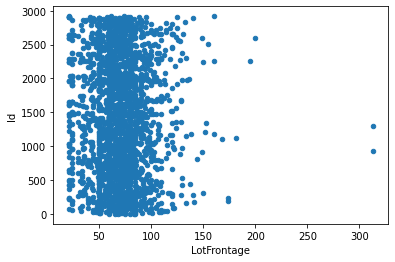

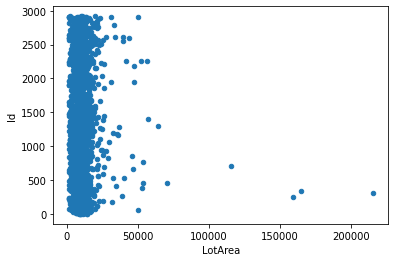

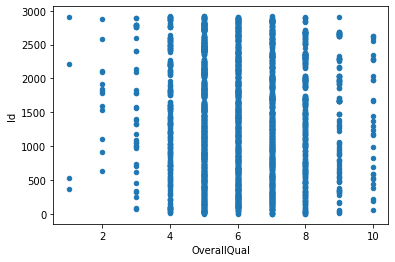

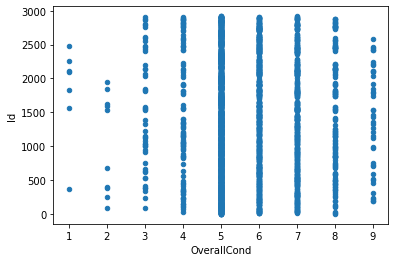

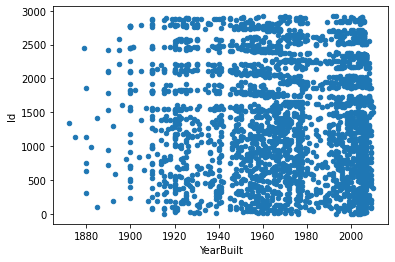

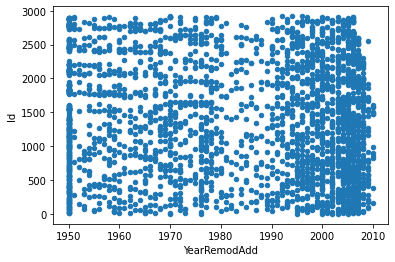

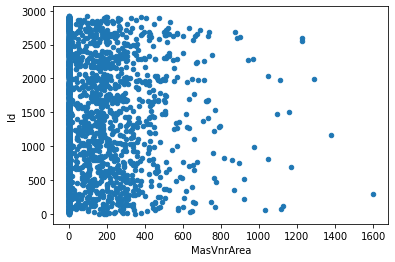

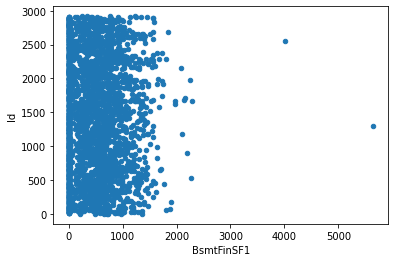

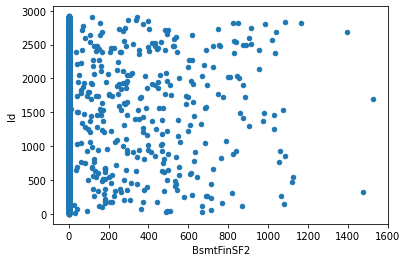

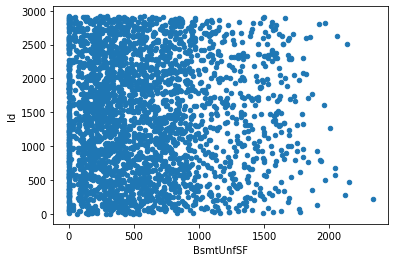

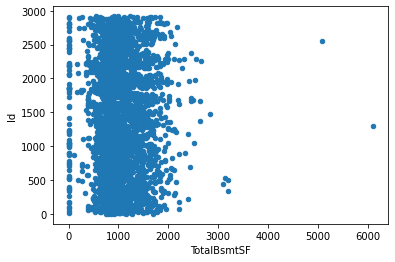

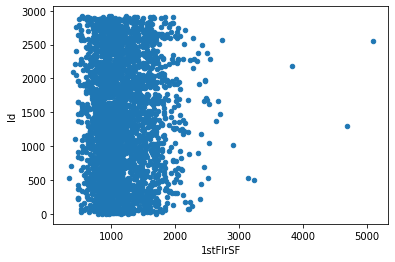

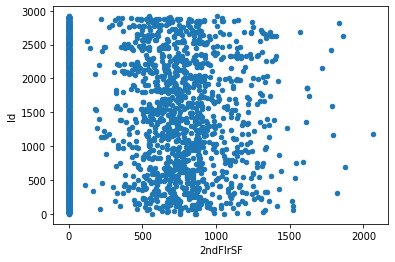

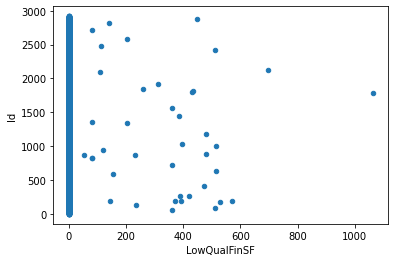

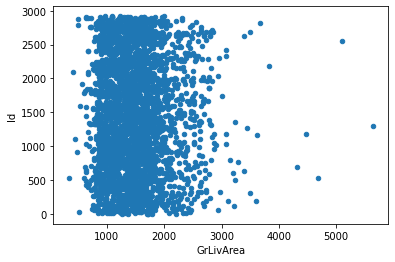

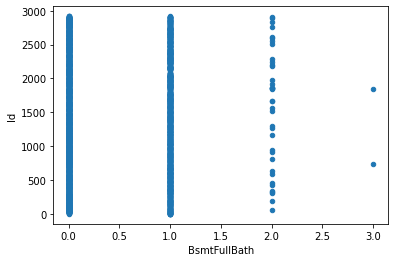

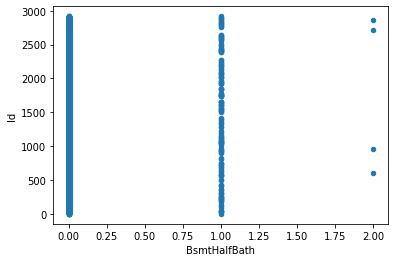

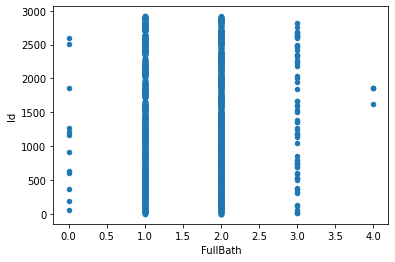

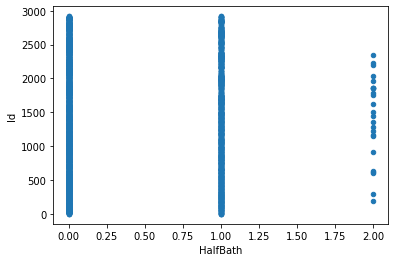

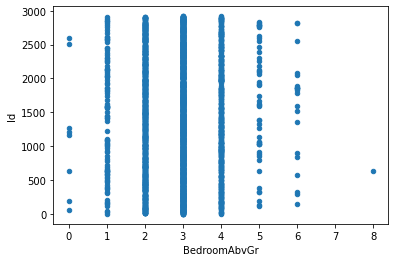

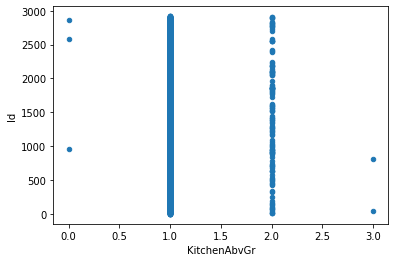

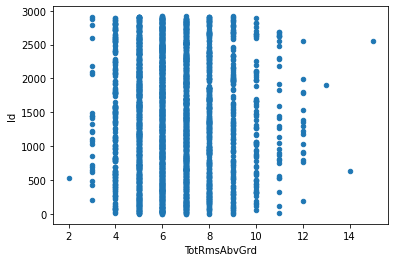

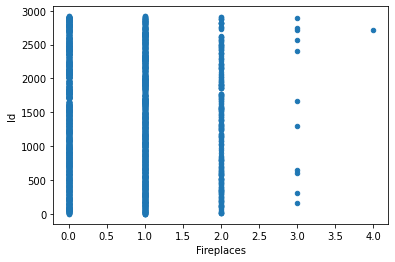

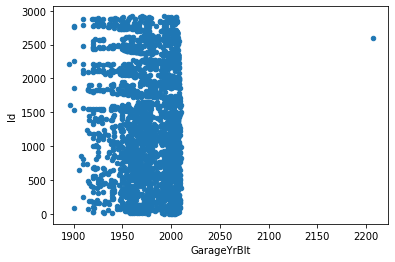

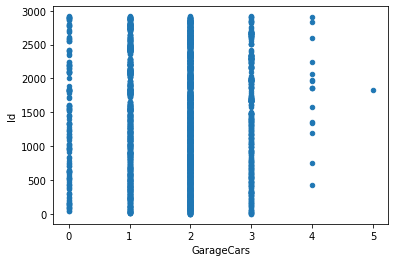

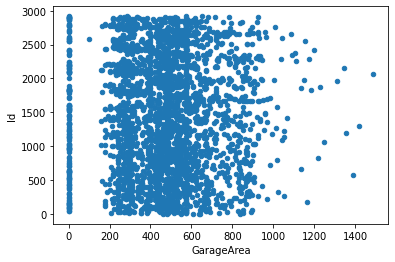

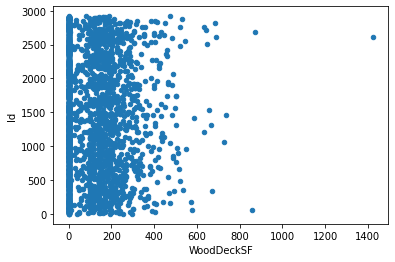

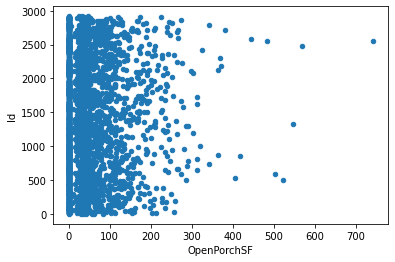

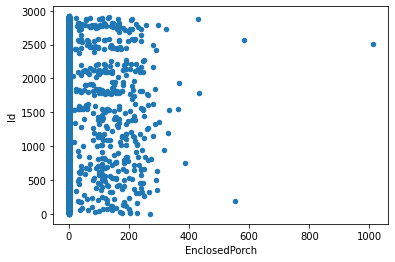

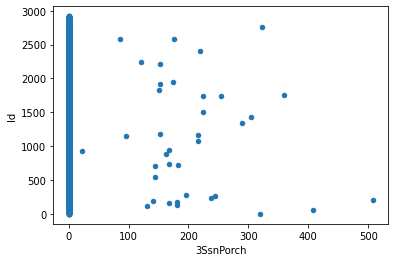

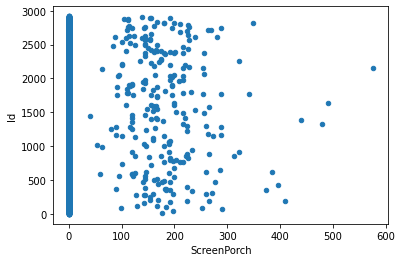

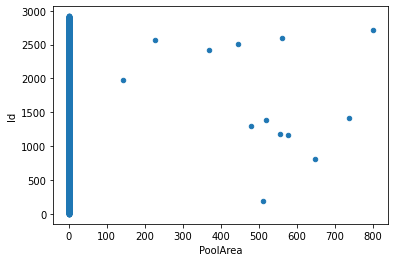

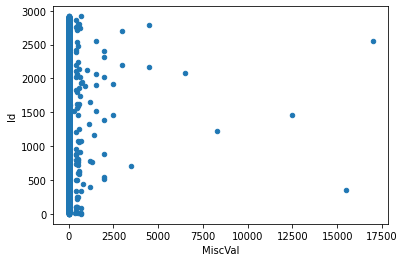

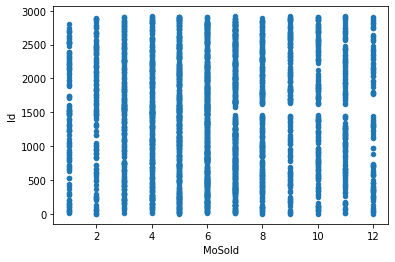

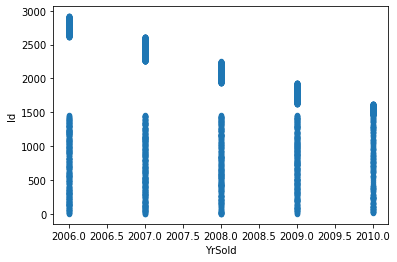

In [76]:
for col in numerical_cols:
  dataset_df.plot(x=col, y='Id', kind='scatter')

In [77]:
def remove_outliers(df, numerical_cols):

  val = df.loc[(df['Id'] == 1132), 'YearBuilt']
  df.loc[df['GarageYrBlt'] > 2200, 'GarageYrBlt'] = val

  for col in numerical_cols:

    upper_lim = df[col].quantile(.95)
    lower_lim = df[col].quantile(.25)
    df.loc[(df[col] > upper_lim), col] = upper_lim
    df.loc[(df[col] < lower_lim), col] = lower_lim

  return df

In [78]:
dataset_df = remove_outliers(dataset_df, ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'WoodDeckSF', 'OpenPorchSF'])

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


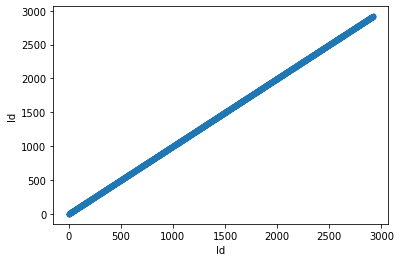

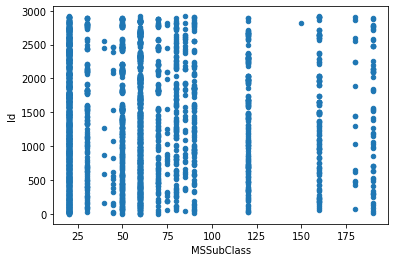

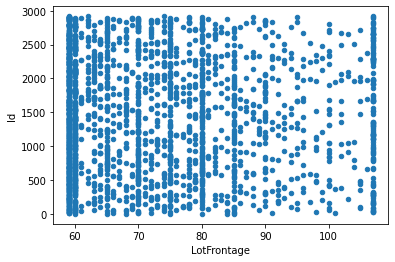

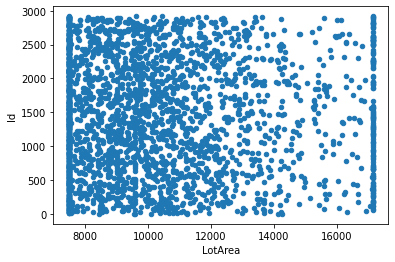

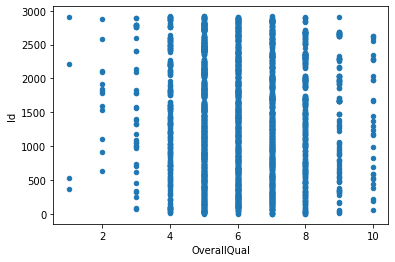

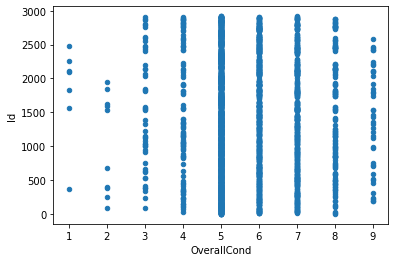

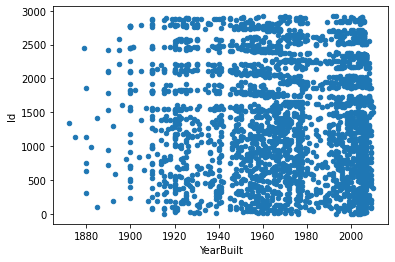

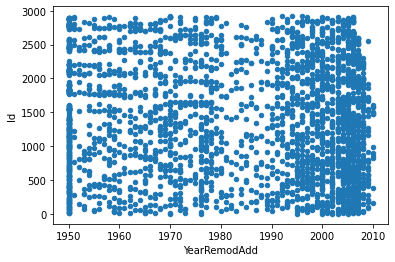

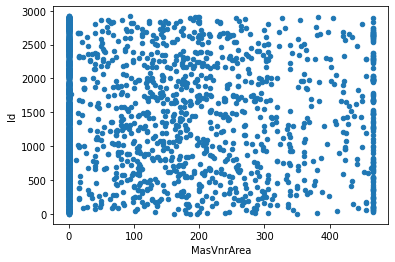

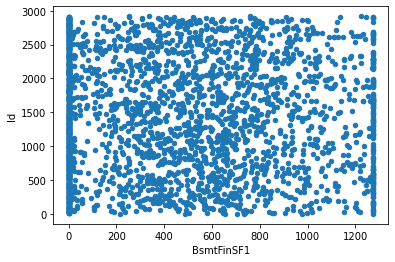

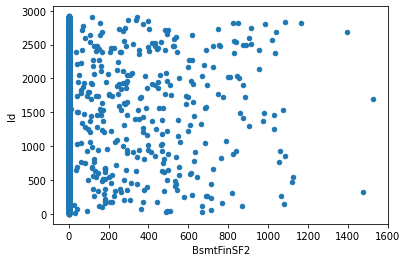

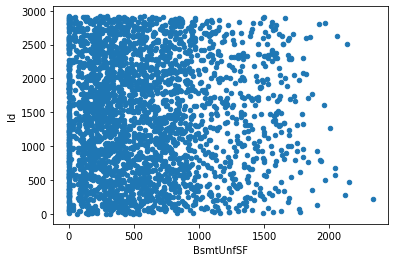

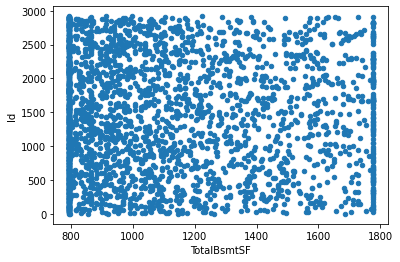

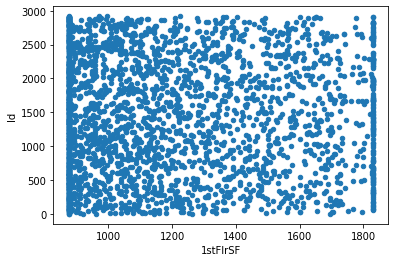

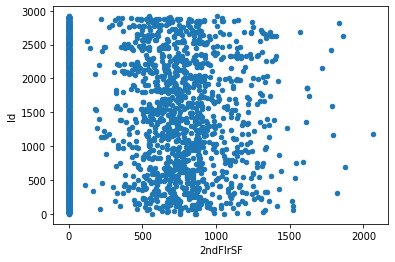

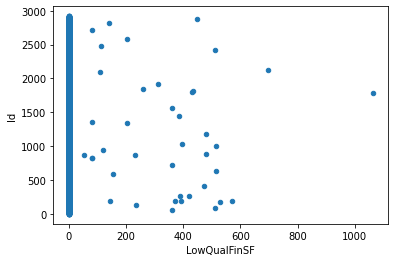

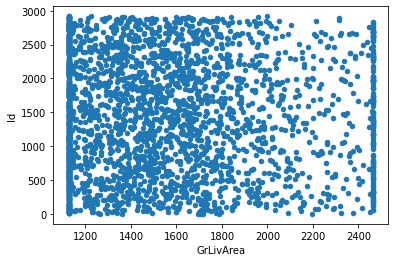

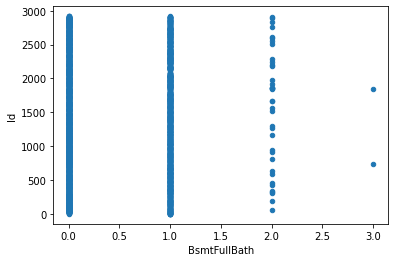

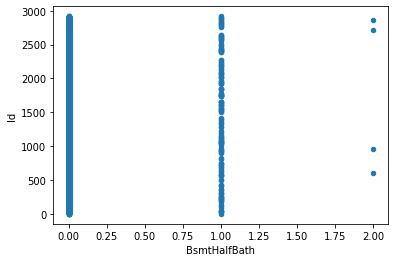

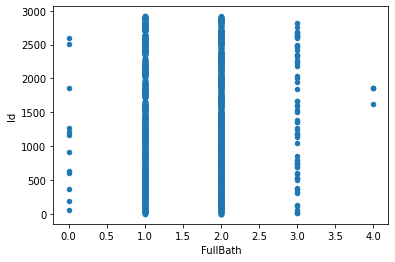

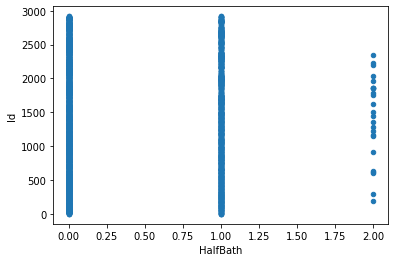

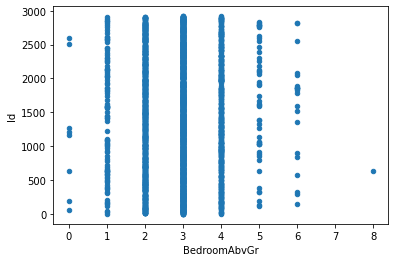

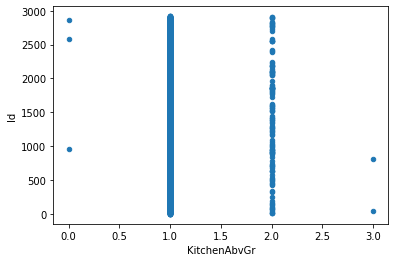

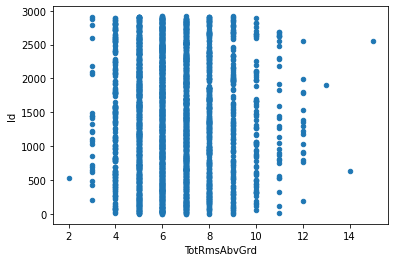

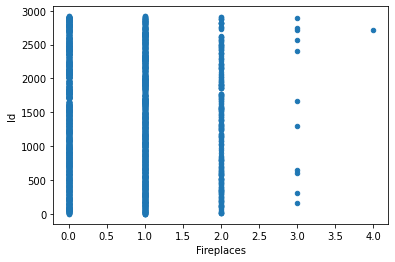

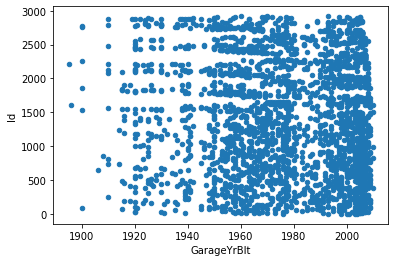

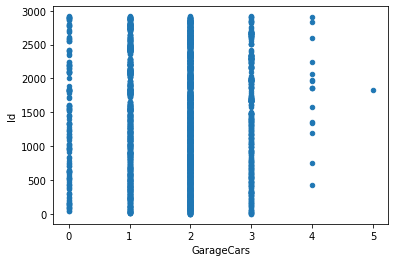

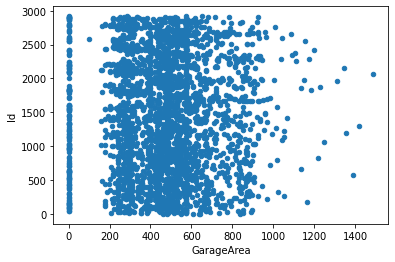

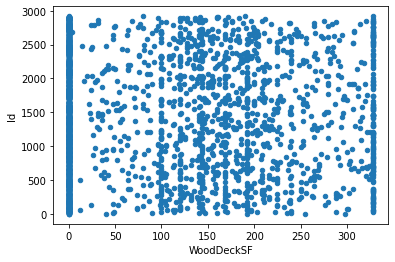

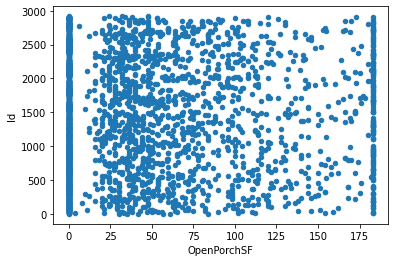

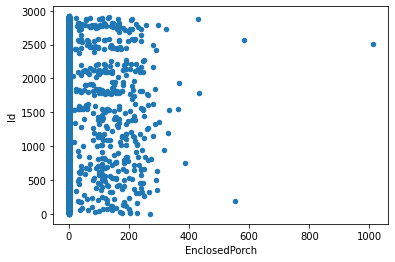

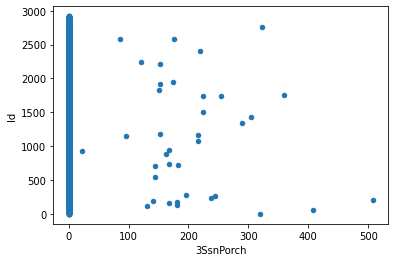

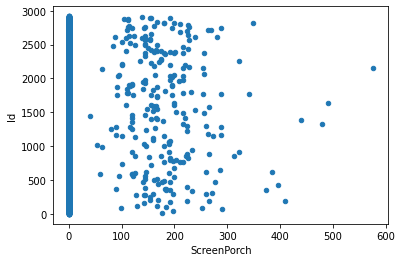

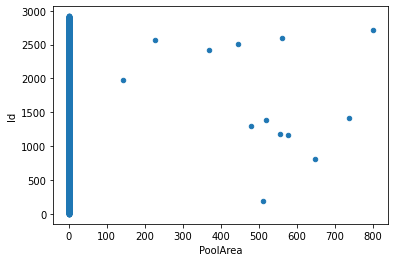

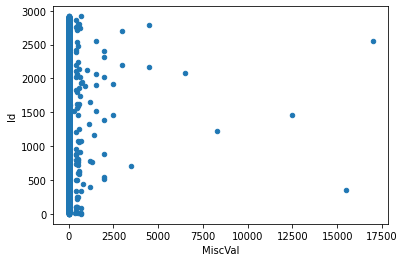

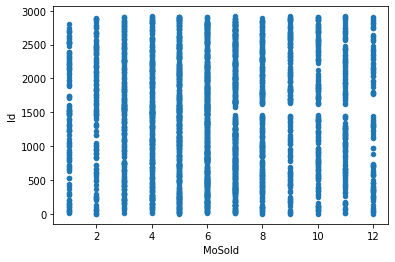

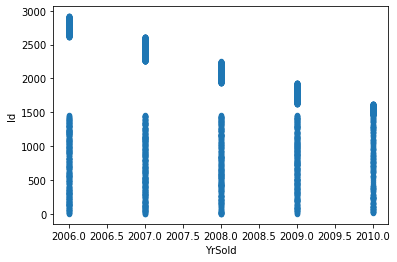

In [79]:
for col in numerical_cols:
  dataset_df.plot(x=col, y='Id', kind='scatter')

In [80]:
def impute_missing_data(df, categorical_cols, numerical_cols):

  for col in ['PoolQC', 'Fence', 'MiscFeature']:
    df[col].fillna('NoVal', inplace=True)

  for col in categorical_cols:
    if col in df.columns:
      print(col + " " + df[col].value_counts().idxmax())
      df[col].fillna(df[col].value_counts().idxmax(), inplace=True)

  for col in numerical_cols:
    if col in df.columns:
      print(col + " " + str(df[col].median()))
      df[col].fillna(df[col].median(), inplace=True)

  return df

In [81]:
dataset_df = impute_missing_data(dataset_df, categorical_cols, numerical_cols)

MSZoning RL
Street Pave
Alley Grvl
LotShape Reg
LandContour Lvl
Utilities AllPub
LotConfig Inside
LandSlope Gtl
Neighborhood NAmes
Condition1 Norm
Condition2 Norm
BldgType 1Fam
HouseStyle 1Story
RoofStyle Gable
RoofMatl CompShg
Exterior1st VinylSd
Exterior2nd VinylSd
MasVnrType None
ExterQual TA
ExterCond TA
Foundation PConc
BsmtQual TA
BsmtCond TA
BsmtExposure No
BsmtFinType1 Unf
BsmtFinType2 Unf
Heating GasA
HeatingQC Ex
CentralAir Y
Electrical SBrkr
KitchenQual TA
Functional Typ
FireplaceQu Gd
GarageType Attchd
GarageFinish Unf
GarageQual TA
GarageCond TA
PavedDrive Y
PoolQC NoVal
Fence NoVal
MiscFeature NoVal
SaleType WD
SaleCondition Normal
Id 1460.0
MSSubClass 50.0
LotFrontage 68.0
LotArea 9453.0
OverallQual 6.0
OverallCond 5.0
YearBuilt 1973.0
YearRemodAdd 1993.0
MasVnrArea 0.0
BsmtFinSF1 368.5
BsmtFinSF2 0.0
BsmtUnfSF 467.0
TotalBsmtSF 989.5
1stFlrSF 1082.0
2ndFlrSF 0.0
LowQualFinSF 0.0
GrLivArea 1444.0
BsmtFullBath 0.0
BsmtHalfBath 0.0
FullBath 2.0
HalfBath 0.0
BedroomAbvGr 3.

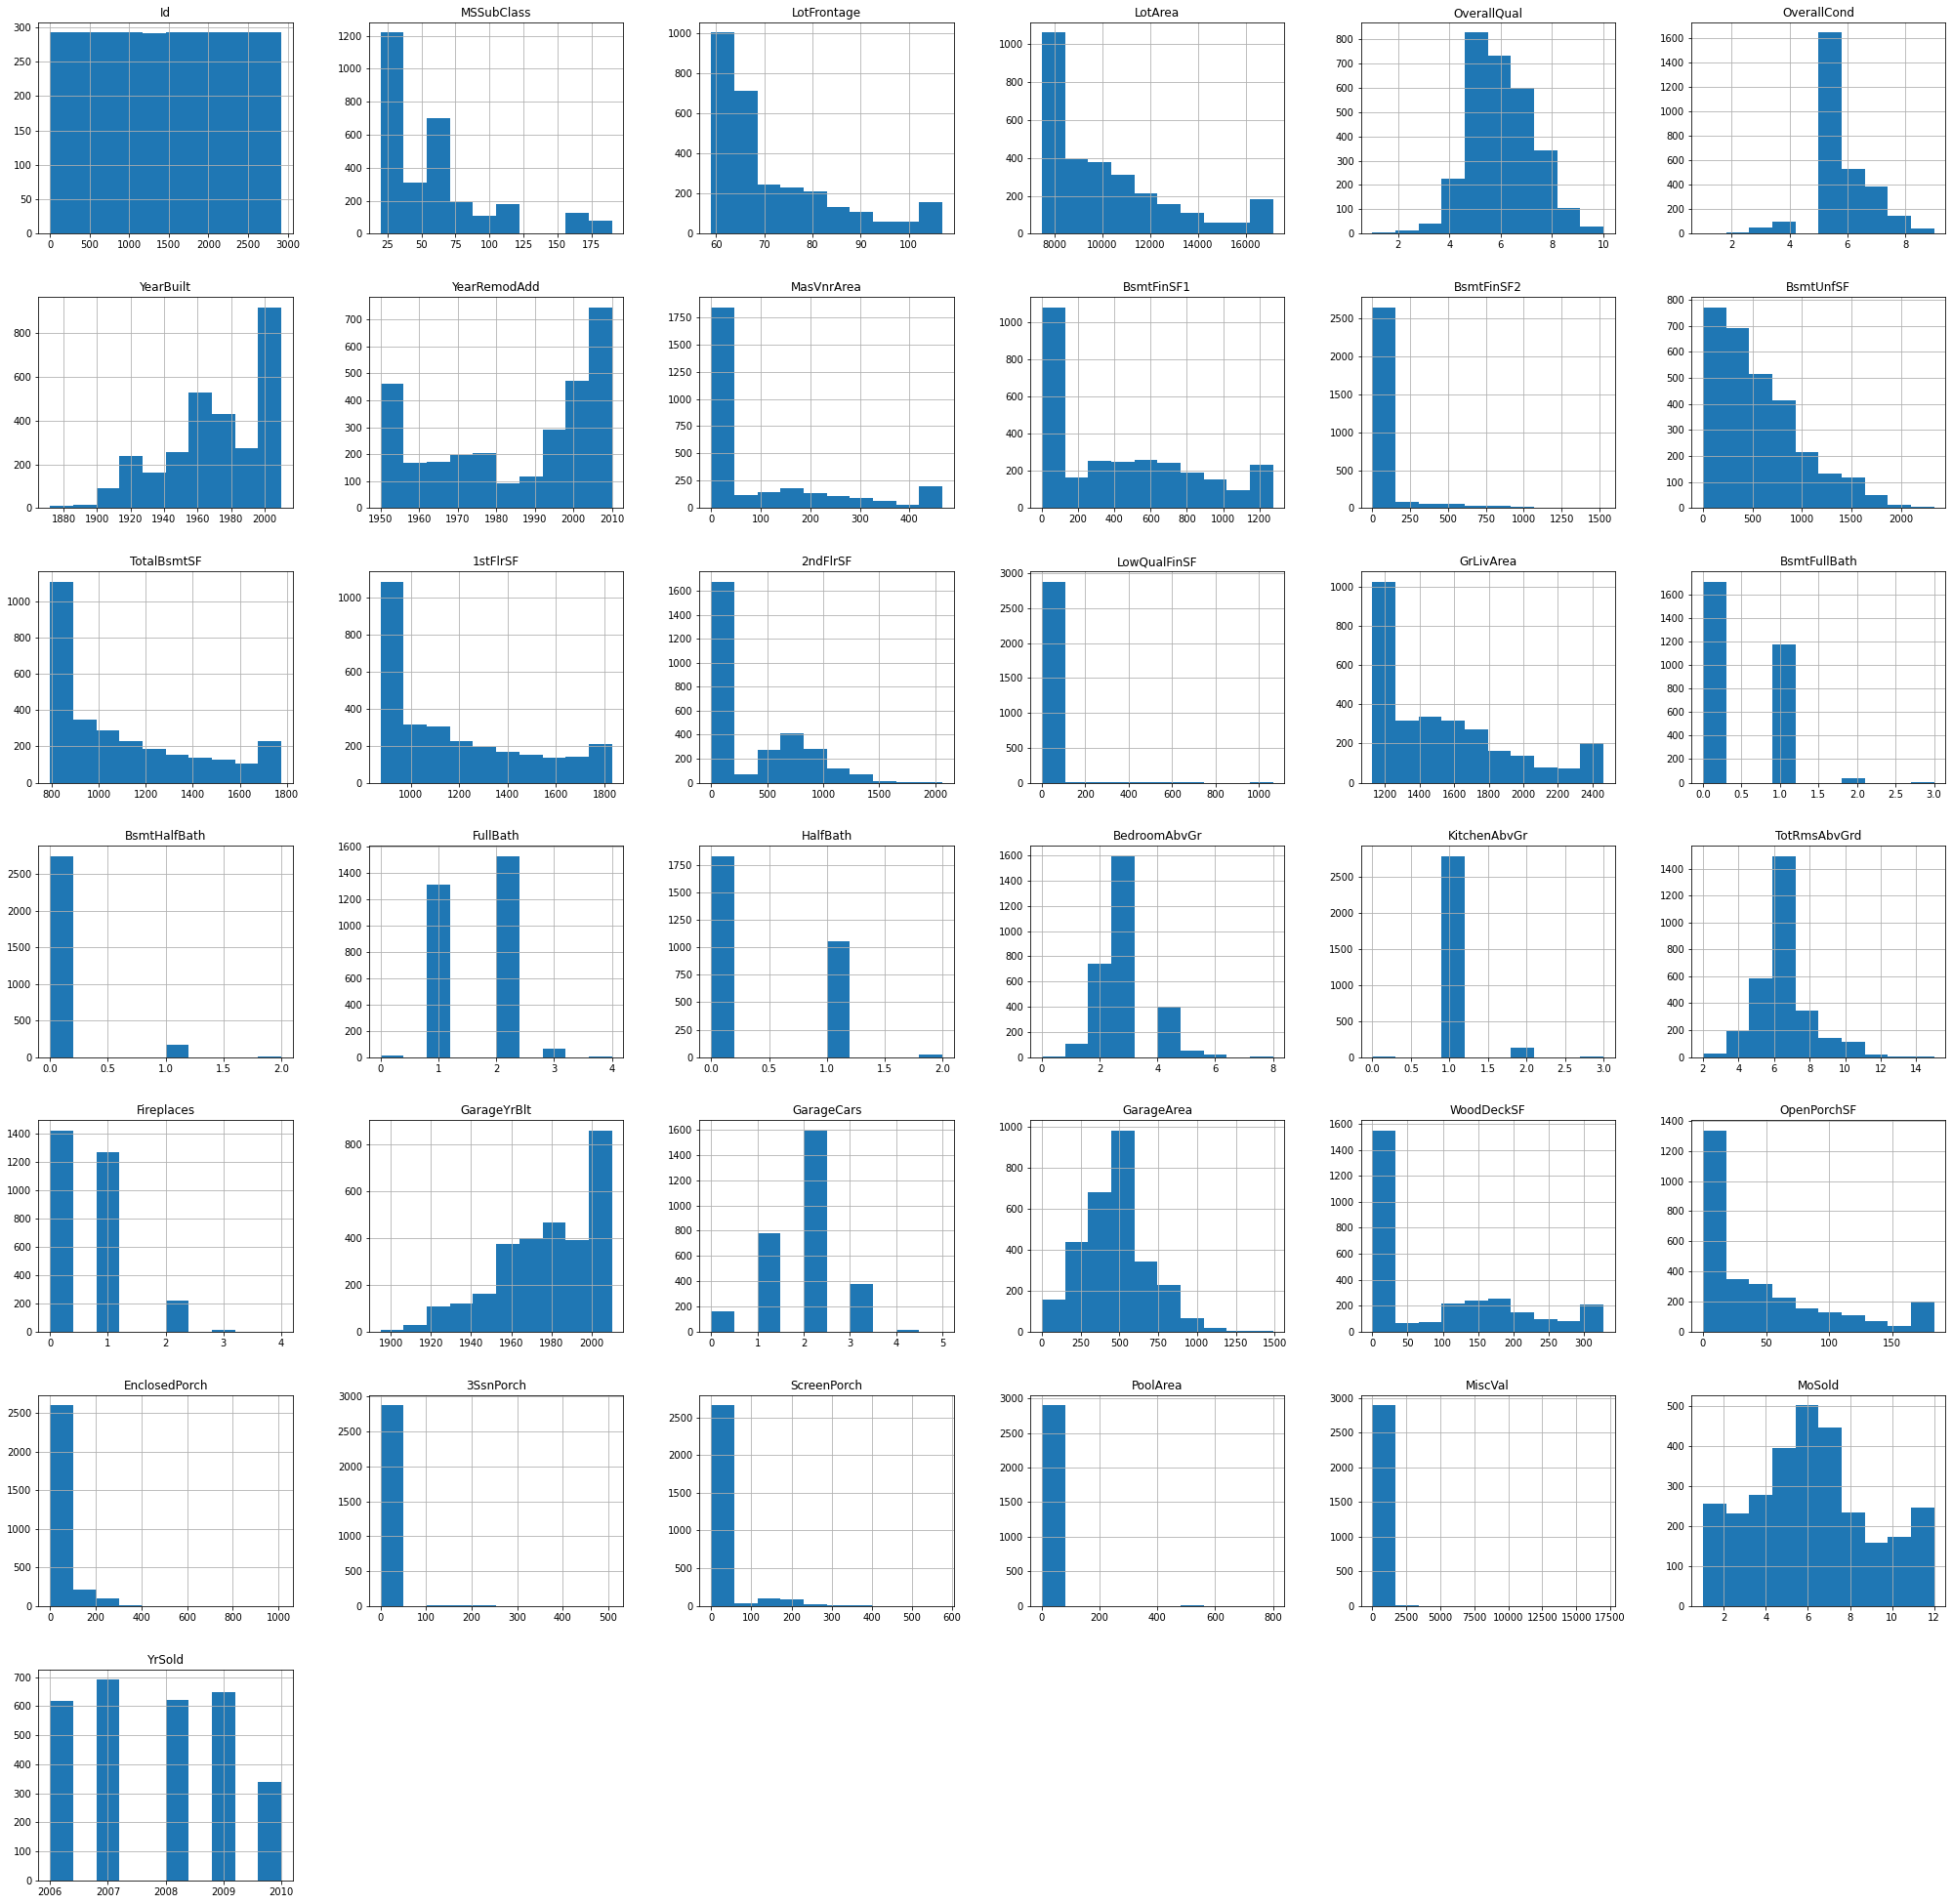

In [82]:
dataset_df.hist(figsize = (35,35))
plt.show()

In [83]:
dataset_df['HasPool'] = dataset_df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
dataset_df['HasBasement'] = dataset_df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
dataset_df['Has2ndFlr'] = dataset_df['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
dataset_df['HasGarage'] = dataset_df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
dataset_df['TotalArea'] = dataset_df['TotalBsmtSF'] + dataset_df['1stFlrSF'] + dataset_df['2ndFlrSF']

In [84]:
dataset_df.shape

(2919, 85)

In [85]:
def label_encode(df, columns):

    for column in columns:
      if column in df.columns:
        df[column] = df[column].astype('category')
        df[column + '_cat'] = df[column].cat.codes
        
    return df

In [86]:
dataset_df = label_encode(dataset_df, categorical_cols)

In [87]:
dataset_df.shape

(2919, 128)

In [88]:
dataset_df = dataset_df.drop(columns=categorical_cols)
dataset_df.shape

(2919, 85)

In [89]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def feature_scaling(df):
    
    scaled = StandardScaler().fit_transform(df)

    return pd.DataFrame(scaled, columns = df.columns)

In [90]:
#dataset_df = feature_scaling(dataset_df)

In [91]:
train = dataset_df.iloc[:len(train_data), :]
test = dataset_df.iloc[len(train_data):, :]

In [92]:
train_y.shape, train.shape, test.shape

((1460,), (1460, 85), (1459, 85))

In [93]:
descr_df = missing_vals_overview(train)
descr_df.loc[descr_df['n_miss'] > 0]

,total,n_miss,%_miss


In [94]:
X_train, X_val, y_train, y_val = train_test_split(train, train_y, test_size=0.3)

In [95]:
from sklearn.metrics import mean_squared_error

def model_trainer(model, X_train, y_train, X_val, y_val):
    t = time.time()
    model = model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    
    rmse_score = mean_squared_error(np.log(y_val), np.log(y_pred), squared=False)

    train_time = time.time() - t
    
    return rmse_score, train_time

In [106]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression, Ridge
from xgboost import XGBRegressor

In [108]:
regerssors = [
              ('GradientBoostingRegressor', GradientBoostingRegressor(random_state=42)),
              ('RandomForestRegressor', RandomForestRegressor(random_state=42)),
              ('AdaBoostRegressor', AdaBoostRegressor(random_state=42)),
              ('LinearRegression', LinearRegression()),
              ('Ridge', Ridge()),
              ('XGBRegressor', XGBRegressor())

]

In [109]:
def run_multiple(regressors, X_train, y_train, X_val, y_val):
   
    result={
    'regressor':[],
    'score':[],
    'train_time':[]
    }
    for name, regressor in regressors:
        score, t = model_trainer(regressor, X_train, y_train, X_val, y_val)
        result['regressor'].append(name)
        result['score'].append(score)
        result['train_time'].append(t)
    results_df = pd.DataFrame.from_dict(result, orient='index').transpose()
    return results_df

In [110]:
run_multiple(regerssors, X_train, y_train, X_val, y_val)

[14:07:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,regressor,score,train_time
0,GradientBoostingRegressor,0.157026,0.636628
1,RandomForestRegressor,0.164678,1.72227
2,AdaBoostRegressor,0.202111,0.31677
3,LinearRegression,0.196408,0.00945282
4,Ridge,0.200531,0.00593758
5,XGBRegressor,0.159246,0.297615


In [130]:
param_dict = {
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 300, 700, 1000],
    'max_depth': [3, 5, 7, 10]
}

In [131]:

grid = GridSearchCV(estimator = GradientBoostingRegressor(random_state=42),
                     param_grid = param_dict,
                     scoring = 'neg_root_mean_squared_error',
                     cv = 5,
                     n_jobs=-1, 
                     verbose=2)

In [132]:
%%time
grid.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 14.6min finished


CPU times: user 11.3 s, sys: 486 ms, total: 11.8 s
Wall time: 14min 44s


GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_n...
                            

In [133]:
grid.best_score_, grid.best_params_

(-23810.19243219989,
 {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1000})

In [136]:
y_pred = grid.best_estimator_.predict(X_val)
    
rmse_score = mean_squared_error(np.log(y_val), np.log(y_pred), squared=False)
rmse_score

0.15557129827354496

In [142]:
submission_pd = pd.read_csv('/content/gdrive/My Drive/My_Colab_Works/Kaggle_House_Price/data/sample_submission.csv')

In [143]:
submission_pd.head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


In [144]:
submission_pd['SalePrice'] = np.resize(y_pred,len(submission_pd))
submission_pd.head()

,Id,SalePrice
0,1461,162402.900890
1,1462,159073.459263
2,1463,297950.075032
3,1464,144130.602218
4,1465,78445.606416


In [145]:
submission_pd.to_csv('/content/gdrive/My Drive/My_Colab_Works/Kaggle_House_Price/data/submission_v1.csv', index=False, encoding='utf-8-sig')